In this section, I will move from the exploratory data analysis to creating a predictive model that forecasts total monthly sales per region.

Modeling Steps Taken:
1. Aggregate Data: Convert daily sales into monthly totals to reduce noise and capture seasonal patterns.
2. Feature Engineering: Create time-based features such as lag values (sales from previous months), rolling averages, and calendar features (month, year).
3. Train & Test Split: – Use a time-based split so the model is trained on past data and tested on unseen future months.
4. Model Training: Fit a Random Forest Regressor to learn patterns and relationships from historical sales trends.
5. Evaluation: Compare the model’s performance to a naive baseline (last month’s sales) using metrics like MAE, RMSE, and MAPE.
6. Forecasting: Generate predictions for future months using the trained model.

This approach allows us to leverage historical patterns to make accurate, actionable forecasts for sales planning and decision-making.

Step 1: Load the tools we’ll need
Just like how you might open Excel and enable add-ins before working with data, in Python we first load the “toolkits” that give us extra powers:

pandas → for working with data tables (like Excel spreadsheets).

matplotlib → for making charts and graphs.

sklearn (scikit-learn) → for building and evaluating prediction models.

numpy → for handling numbers and calculations efficiently.

pathlib → for handling file and folder paths safely.

In [1]:
#Import Libraries

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

Step 2: Load the raw sales data
Now we open the dataset we’ll be working with. Think of this like opening an Excel file that has all the company’s order history.

We point to the file location (train.csv).

We make sure the Order Date column is treated as a real calendar date instead of just plain text — this is important because we’ll want to analyze sales trends over time.

In [2]:
#Load the raw data
data_path = Path("..") / "data" / "data_raw" / "train.csv"
df = pd.read_csv(data_path, parse_dates=['Order Date'])  #Ensure 'Order Date' becomes datetime
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')

Step 3: Verify and clean the dataset
This block makes sure the raw file contains the key information we need:

Order Date → when the sale happened

Sales → how much money the sale generated

Region → which part of the country it came from

Postal Code → the customer’s location

If any of those are missing, the code will stop so we don’t build a model on incomplete data.

We also:

Print how many rows (transactions) we have.

Print the earliest and latest dates to confirm the timeframe covered.

Replace any missing values with zero, so calculations and models don’t break later.

In [3]:
# Ensure columns needed are included
expected_cols = {'Order Date', 'Sales', 'Region', 'Postal Code'}
missing = expected_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing required column(s): {missing}")

print(f"Raw rows: {len(df)}")
print("Date range:", df['Order Date'].min(), "→", df['Order Date'].max())

# Replace missing values if any
df = df.fillna(0)


Raw rows: 9800
Date range: 2015-01-02 00:00:00 → 2018-12-11 00:00:00


Step 4: Prepare the date column for analysis

First, we tidy up the column names in case there are extra spaces.

Next, we make sure Order Date is stored as an actual calendar date.

Finally, we create a new column called Month. This groups all orders into their calendar month, which makes it easier to analyze sales trends over time (like monthly revenue).

In [4]:
# Clean up column names (strip spaces)
df.columns = df.columns.str.strip()

# Convert Order Date to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')

# Add a 'Month' column for grouping
df['Month'] = df['Order Date'].dt.to_period('M').dt.to_timestamp()



In [ ]:
Step 5: Summarize monthly sales by region and postal code
This step organizes the raw transaction data into a cleaner summary:

We group the data by Month, Region, and Postal Code.

For each group, we calculate the total Sales.

We fix postal codes so they display correctly:

Stored as numbers for calculations.

Also stored as text with leading zeros (important because some U.S. ZIP codes start with “0”).

We create a Sales_fmt column that shows sales in a readable, dollar-formatted way (like $1,200).

Finally, we display a quick preview of the cleaned summary table.

In [5]:
monthly = (
    df.groupby(['Month', 'Region', 'Postal Code'], dropna=False)['Sales']
      .sum()
      .reset_index()
      .sort_values(['Month', 'Region', 'Postal Code'])
)

# Keep copy of zip codes
monthly['Postal Code'] = monthly['Postal Code'].astype('Int64')  # nullable integer

# Preserve leading zeros for zip codes, store as string
monthly['Postal Code_str'] = monthly['Postal Code'].astype('string').str.zfill(5)

# Add a formatted column for display, keep Sales numeric
monthly['Sales_fmt'] = monthly['Sales'].map(lambda x: f"${x:,.0f}")

# Quick peek
display(monthly[['Month', 'Region', 'Postal Code_str', 'Sales_fmt']].head())

,Month,Region,Postal Code_str,Sales_fmt
0,1970-01-01,Central,46203,"$2,299"
1,1970-01-01,Central,46226,"$1,338"
2,1970-01-01,Central,46350,$526
3,1970-01-01,Central,46368,$16
4,1970-01-01,Central,46514,$171


Step 6: Prepare the target column for modeling
Machine learning models need a clean numeric value to predict.

Here we make sure the Sales column is stored as a numeric type (Sales_num).

This becomes the target variable our models will try to predict.

In [6]:
#Keep sales numeric for modeling
monthly['Sales_num'] = monthly['Sales'].astype(float)  # keep a clean numeric target


Step 7: Roll up sales data to the region level
To understand overall performance, we combine all postal codes within each region.

For each Month and Region, we calculate the total sales.

This gives us a clean view of monthly revenue trends across the different regions.

In [7]:
#Aggregate sales by region
region_sales = monthly.groupby(['Month','Region'])['Sales_num'].sum().reset_index()


Step 8: Create features for forecasting
To help the model make predictions, we add new columns that capture time-based patterns:

Lag features → Sales from 1, 2, and 3 months ago (like saying, “last quarter’s performance influences this month”).

Rolling average → The 3-month moving average, which smooths out short-term ups and downs.

Calendar features → Month number and year, so the model can recognize seasonality (for example, holiday sales spikes in December).

These features give the model the kind of historical context a human would naturally use when forecasting sales.

In [8]:
#Create time based features
region_sales = region_sales.sort_values(['Region','Month'])

# Lag features
region_sales['lag_1'] = region_sales.groupby('Region')['Sales_num'].shift(1)
region_sales['lag_2'] = region_sales.groupby('Region')['Sales_num'].shift(2)
region_sales['lag_3'] = region_sales.groupby('Region')['Sales_num'].shift(3)

# Rolling mean
region_sales['rolling_3'] = region_sales.groupby('Region')['Sales_num'].shift(1).rolling(3).mean()

# Calendar features
region_sales['month_num'] = region_sales['Month'].dt.month
region_sales['year'] = region_sales['Month'].dt.year


Step 9: Prepare the dataset for machine learning
Now that we’ve created time-based features, we’re ready to build a modeling dataset:

Target variable (y) → The sales number we want the model to predict.

Feature set (X) → All other information (lagged sales, rolling averages, region, etc.).

We convert text categories (like Region) into numeric form using one-hot encoding, so the model can understand them.

Next, we split the dataset into:

Training set → All data before the most recent 12 months. This is what the model learns from.

Test set → The most recent 12 months. This is held out to check if the model can make accurate forecasts on new data.

Finally, we print the shape (size) of each dataset and a sample of the features to confirm everything looks correct.

In [9]:
# Use region_sales (with lags/rolling features) as modeling dataset
df_model = region_sales.copy()

# Target variable
y = df_model['Sales_num']

# Drop target + date
X = df_model.drop(columns=['Sales_num','Month'])

# One-hot encode categorical columns (e.g., Region, Postal Code)
X = pd.get_dummies(X, drop_first=True)

# Train/test split (last 12 months)
cutoff = df_model['Month'].max() - pd.DateOffset(months=12)
train_idx = df_model['Month'] <= cutoff
test_idx  = df_model['Month'] > cutoff

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)
print("Sample columns:", list(X_train.columns)[:10])


Train shape: (148, 9)
Test shape : (48, 9)
Sample columns: ['lag_1', 'lag_2', 'lag_3', 'rolling_3', 'month_num', 'year', 'Region_East', 'Region_South', 'Region_West']


Step 10: Train and evaluate the model
Now we train a Random Forest model, which is a popular machine learning method that combines many decision trees to make more reliable predictions.

What is a Decision Tree?

A decision tree is like a flowchart a manager might draw:

“If Region = West, then… If Month = December, then…”

The tree keeps splitting the data into smaller and smaller groups until it makes a prediction.

Trees are easy to understand, but on their own they can overfit (memorize the past instead of generalizing).

What is a Random Forest?

Instead of building just one tree, we build hundreds of trees, each slightly different.

Each tree sees a random sample of the data and a random subset of features.

The final prediction is the average of all the trees’ outputs.

This makes the model much more stable and accurate, because it doesn’t rely on any single tree’s mistakes.

Why measure errors (RMSE and MAE)?

RMSE (Root Mean Squared Error) → Like saying, “On average, the forecast is off by this many sales units, but we penalize larger mistakes more heavily.”

MAE (Mean Absolute Error) → The average size of mistakes, in dollars of sales. Easier to explain directly: “On average, the model is off by about $X.”

Together, these metrics show whether the Random Forest is making reasonable predictions, and whether it’s an improvement over simpler baselines.



The model is trained on the training dataset (all months before the last 12).

Then it predicts sales for the test dataset (the last 12 months).

To measure accuracy, we use two metrics:

RMSE (Root Mean Squared Error) → Tells us how far off the predictions are from the actual sales, on average.

MAE (Mean Absolute Error) → Another measure of average error, easier to interpret directly in sales units (dollars).

These numbers let us judge whether the model’s forecasts are close enough to reality to be useful for planning.

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rf_model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print(f"Random Forest RMSE: {rmse_rf:,.2f}")
print(f"Random Forest MAE : {mae_rf:,.2f}")


Random Forest RMSE: 3,233.62
Random Forest MAE : 2,513.25


Step 11: Confirm the time coverage
Before moving further, we double-check the range of months in the dataset.

This prints the earliest and latest month available.

It reassures us that the dataset covers the full period we expect, and that no months were lost during cleaning and feature creation.

In [11]:
print(region_sales['Month'].min(), "→", region_sales['Month'].max())


1970-01-01 00:00:00 → 2018-12-01 00:00:00


Step 12: Compare to a simple baseline
A good forecast model should be better than a “naive guess.” Here we test that idea:

Naive baseline → We assume this month’s sales will simply be the same as last month (lag_1).

Random Forest model → The machine learning model we trained earlier.

We evaluate both using the same error metrics:

RMSE (Root Mean Squared Error) → How far off the predictions are on average, with big mistakes penalized more.

MAE (Mean Absolute Error) → The average size of the prediction errors in actual sales dollars.

The comparison shows whether the Random Forest is truly adding value beyond a simple “last month equals this month” approach. This is a key test of whether the model is useful for real forecasting.

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# --- Naive Baseline ---
# Rebuild test DataFrame (last 12 months)
cutoff = df_model['Month'].max() - pd.DateOffset(months=12)
test = df_model[df_model['Month'] > cutoff].copy()

# Naive forecast = lag_1
y_test_eval = test['Sales_num']
y_pred_naive = test['lag_1']

# Drop rows where lag_1 is missing
mask = ~y_pred_naive.isna()
y_test_eval = y_test_eval[mask]
y_pred_naive = y_pred_naive[mask]

rmse_naive = np.sqrt(mean_squared_error(y_test_eval, y_pred_naive))
mae_naive = mean_absolute_error(y_test_eval, y_pred_naive)

# --- Random Forest (already trained) ---
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print("\n--- Model Comparison ---")
print(f"Naive RMSE: {rmse_naive:,.2f} | Random Forest RMSE: {rmse_rf:,.2f}")
print(f"Naive MAE : {mae_naive:,.2f} | Random Forest MAE : {mae_rf:,.2f}")

print(f"The Random Forest model reduces error compared to the naive baseline: "
f"RMSE drops by about 1,000 units and MAE by about 700, showing that the model adds"
      f"real forecasting value beyond simply repeating last month’s sales.")




--- Model Comparison ---
Naive RMSE: 4,260.13 | Random Forest RMSE: 3,233.62
Naive MAE : 3,250.74 | Random Forest MAE : 2,513.25


Step 13: Visualize the forecasts
Numbers alone can be hard to interpret — so we create a chart that compares:

Actual sales (solid line with circles).

Random Forest model forecast (dashed line with X markers).

Naive baseline forecast (dotted line with square markers).

This visualization makes it clear how well the Random Forest tracks real sales compared to the naive guess.

The naive forecast often lags behind actual sales because it only repeats the last month’s value.

The Random Forest captures more of the ups and downs, showing it’s learning from historical patterns.

We can easily change which region is displayed (Central, East, South, West) to examine performance across different parts of the business.

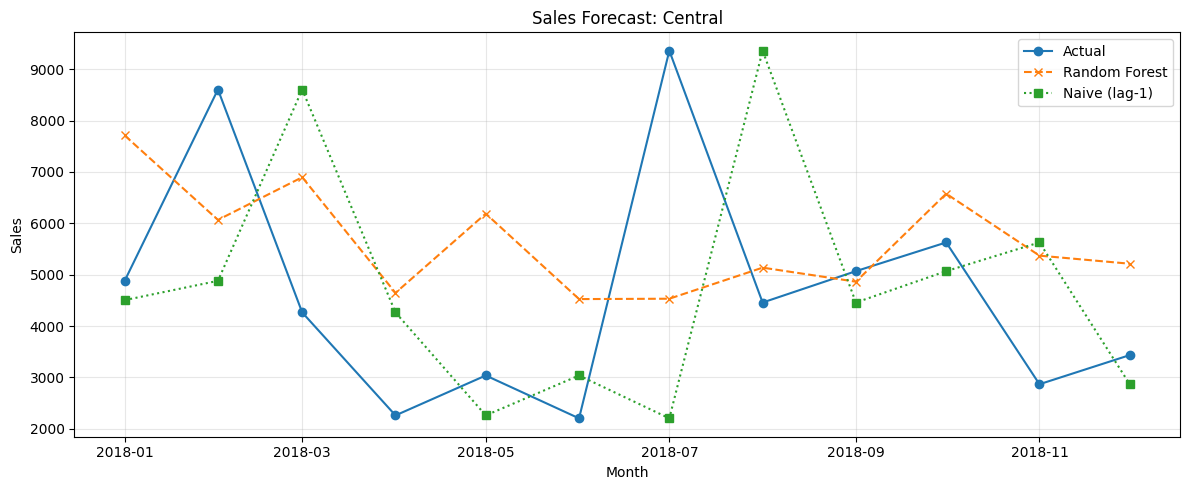

In [13]:
# --- Naive forecast for plotting ---
y_pred_naive = test['lag_1']

# Drop rows where lag_1 is missing
mask = ~y_pred_naive.isna()
y_test_plot = test.loc[mask, 'Sales_num']
y_pred_naive_plot = y_pred_naive[mask]
months_plot = test.loc[mask, 'Month']

# --- Plot ---
# Build a test-set frame aligned with predictions
test_idx = y_test.index
df_plot = df_model.loc[test_idx, ['Month','Region','Sales_num','lag_1']].copy()
df_plot['pred_rf'] = y_pred_rf
df_plot = df_plot.sort_values(['Region','Month'])

# Choose a region to visualize
region_to_plot = 'Central'  

sub = df_plot[df_plot['Region'] == region_to_plot].copy()

# Drop rows with missing naive (lag_1) only for that curve
mask_naive = sub['lag_1'].notna()

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(sub['Month'], sub['Sales_num'], marker='o', label='Actual')
plt.plot(sub['Month'], sub['pred_rf'], linestyle='--', marker='x', label='Random Forest')
plt.plot(sub.loc[mask_naive, 'Month'], sub.loc[mask_naive, 'lag_1'],
         linestyle=':', marker='s', label='Naive (lag-1)')

plt.title(f"Sales Forecast: {region_to_plot}")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



Step 14: Build reusable plotting utilities
To make the analysis professional and flexible, we build helper functions that automatically prepare data for visualization:

Column guessing functions → These look at the dataset and figure out which columns represent dates, regions, actual sales, and predictions. This makes the plotting function more general-purpose, so it can work with differently named datasets.

Harmonization step → Once guessed, the column names are standardized to:

date → when the sale happened

group → region or category

actual → the real sales numbers

pred → the forecasted numbers

Plotting function → Produces small-multiple charts (one per region, store, or group) so we can visually compare forecasts across the entire business.

This step shows how we can turn a one-off analysis into a reusable tool — something a business analyst or data scientist could apply to many different datasets with minimal adjustments.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _guess_column(df, candidates, must_be_numeric=False, exclude=set()):
    cols = [c for c in df.columns if c not in exclude]
    #Try exact/ci matches first
    for cand in candidates:
        for c in cols:
            if c == cand or c.lower() == cand.lower():
                if not must_be_numeric or pd.api.types.is_numeric_dtype(df[c]):
                    return c
    #Fallback: numeric and non-numeric
    if must_be_numeric:
        for c in cols:
            if pd.api.types.is_numeric_dtype(df[c]):
                return c
    else:
        for c in cols:
            if not pd.api.types.is_numeric_dtype(df[c]):
                return c
    return None

def _guess_group_col(df, date_col):
    #Prefer common group names
    common = ["region","store","segment","category","item","series","group","dept","department","state","market"]
    for cand in common:
        if cand in df.columns: return cand
        if cand.capitalize() in df.columns: return cand.capitalize()
    # otherwise pick a low-cardinality non-date, non-numeric column
    candidates = [c for c in df.columns if c != date_col]
    # try non-numeric with few uniques
    non_num = [c for c in candidates if not pd.api.types.is_numeric_dtype(df[c])]
    if non_num:
        return sorted(non_num, key=lambda c: df[c].nunique())[0]
    # last resort: any column with few uniques
    few_unique = sorted(candidates, key=lambda c: df[c].nunique())
    return few_unique[0] if few_unique else None

def harmonize_df_for_plot(df):
    #Date
    date_col = _guess_column(df, ["date","ds","Date","timestamp","Datetime","time","Time"])
    if date_col is None:
        raise ValueError("Could not infer a date column. Add a column named 'date' (or ds/timestamp).")
    #Ensure datetime
    if not np.issubdtype(df[date_col].dtype, np.datetime64):
        with pd.option_context("mode.chained_assignment", None):
            df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    if df[date_col].isna().all():
        raise ValueError(f"Date column '{date_col}' could not be parsed to datetimes.")
    # actual
    actual_col = _guess_column(df, ["actual","y","y_true","truth","sales","target","observed"], must_be_numeric=True)
    #Prediction
    pred_col   = _guess_column(df, ["pred","yhat","forecast","prediction","predicted","y_pred"], must_be_numeric=True,
                               exclude={actual_col} if actual_col else set())
    if actual_col is None or pred_col is None:
        raise ValueError("Could not infer numeric columns for actual/prediction. "
                         "Try renaming your columns to include 'actual' and 'pred' (or 'sales'/'forecast').")
    #Group
    group_col = _guess_group_col(df, date_col)
    if group_col is None:
        # if no grouping col, create a dummy group so it still plots
        group_col = "_group"
        df = df.copy()
        df[group_col] = "All"

    #Standardize names
    out = df[[date_col, group_col, actual_col, pred_col]].copy()
    out.columns = ["date","group","actual","pred"]
    return out

# Align df_plot to what the plotting function expects
df_plot_compat = df_plot.rename(
    columns={
        'Month': 'Date',
        'Sales_num': 'actual',
        'pred_rf': 'pred'
    }
)

def plot_regions_small_multiples(df_plot_compat, title="Forecast vs Actual", same_ylim=True, export_path=None, ncols=3):
    """
    Works with flexible column names:
    - date: date/ds/timestamp/...
    - group: region/store/segment/category/... (auto-detected)
    - actual: actual/y/sales/target/...
    - pred: pred/yhat/forecast/...
    """
    dfh = harmonize_df_for_plot(df_plot_compat)
    groups = dfh["group"].astype(str).unique()
    n = len(groups)
    ncols = max(1, ncols)
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 3*nrows), sharey=same_ylim)
    if nrows * ncols == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    #Consistent y-limit
    y_min = dfh["actual"].min() if same_ylim else None
    y_max = dfh["actual"].max() if same_ylim else None

    for i, g in enumerate(groups):
        ax = axes[i]
        tmp = dfh[dfh["group"] == g].sort_values("Month")
        ax.plot(tmp["Month"], tmp["actual"], label="Actual")
        ax.plot(tmp["Month"], tmp["pred"],   label="Predicted")
        ax.set_title(str(g))
        if same_ylim:
            ax.set_ylim(y_min, y_max)
        ax.tick_params(axis="x", rotation=0)
        if i == 0:
            ax.legend()

    # hide any unused axes
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(title, fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.95])

    if export_path:
        plt.savefig(export_path, dpi=200, bbox_inches="tight")
        print(f"Saved plot to {export_path}")
    plt.show()


Step 14: Standardize columns and export the final chart
Different steps earlier may name columns slightly differently (e.g., “Date” vs “Month”). Before plotting, we standardize names so the charting function works consistently:

Convert date and region columns to a common format (Month, Region).

Align numeric fields to actual (true sales) and pred (model forecast).

Ensure the Month column is recognized as a date and sort the data for clean axes.
Finally, we generate the multi-region forecast chart and save it to the project’s models folder so it can be reused in reports or the README.

Saved plot to C:\Users\Jaime\Projects\Sales-Forecast-Dash\models\forecast_regions.png


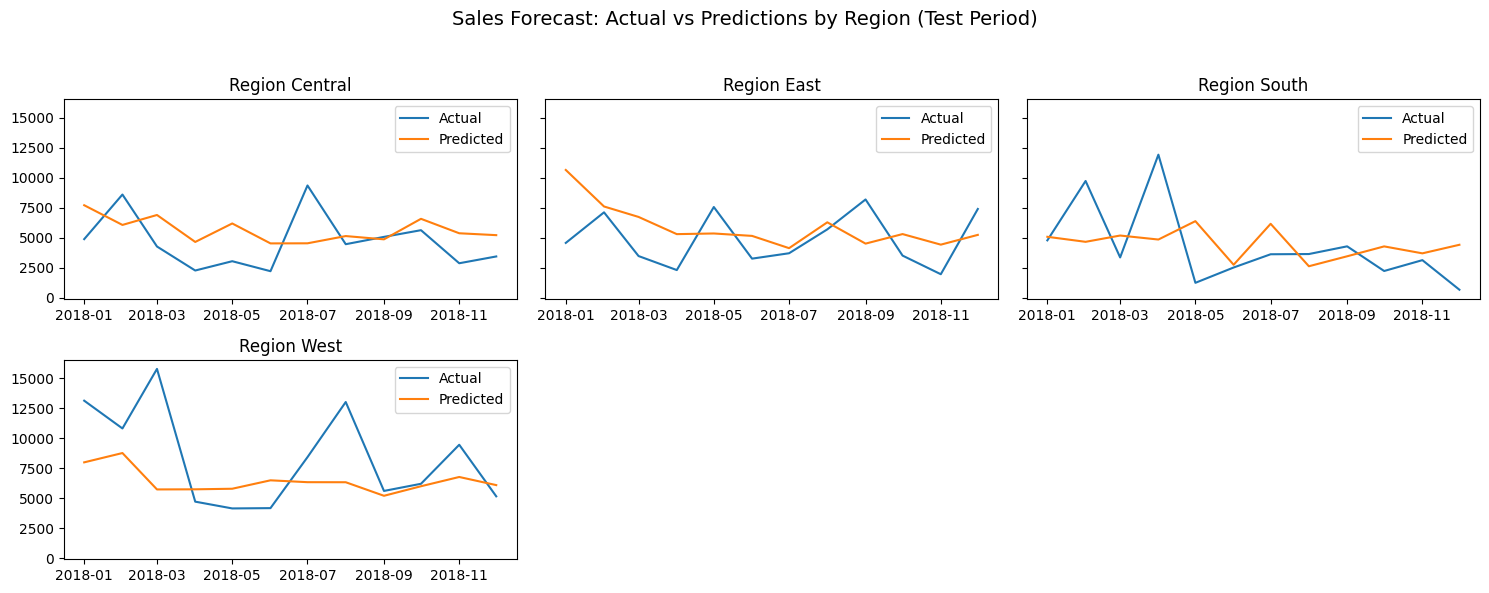

Saved plot to: C:\Users\Jaime\Projects\Sales-Forecast-Dash\models\forecast_regions.png


In [16]:
from pathlib import Path
import pandas as pd

# Ensure /models exists one level up from the notebook (Sales-Forecast-Dash/models)
project_root = Path.cwd().parent
models_dir = project_root / "models"
models_dir.mkdir(exist_ok=True)

export_path = models_dir / "forecast_regions.png"

# Normalize column names to what plot_regions_small_multiples expects:
# Required final names: Month, Region, actual, pred
cols = list(df_plot.columns)

name_map = {}

# Date-like column → Month
if "Month" in cols:
    pass
elif "Date" in cols:
    name_map["Date"] = "Month"
elif "month" in cols:
    name_map["month"] = "Month"

# Region casing
if "Region" in cols:
    pass
elif "region" in cols:
    name_map["region"] = "Region"

# Actual series (lowercase 'actual')
if "actual" in cols:
    pass
elif "Actual" in cols:
    name_map["Actual"] = "actual"
elif "Sales_num" in cols:
    name_map["Sales_num"] = "actual"

# Prediction series (lowercase 'pred')
if "pred" in cols:
    pass
elif "Pred" in cols:
    name_map["Pred"] = "pred"
elif "pred_rf" in cols:
    name_map["pred_rf"] = "pred"

df_plot_compat = df_plot.rename(columns=name_map)

# Final sanity check
needed = ["Month", "Region", "actual", "pred"]
missing = [c for c in needed if c not in df_plot_compat.columns]
if missing:
    raise KeyError(
        f"df_plot is missing required columns: {missing}. "
        f"Available columns after rename: {list(df_plot_compat.columns)}. "
        f"Applied rename map: {name_map}"
    )

# Ensure Month is datetime for nicer x-axis 
try:
    df_plot_compat["Month"] = pd.to_datetime(df_plot_compat["Month"])
except Exception:
    pass

# Keep things ordered
df_plot_compat = df_plot_compat.sort_values(["Region", "Month"])

# Plot and export
plot_regions_small_multiples(
    df_plot_compat,
    title="Sales Forecast: Actual vs Predictions by Region (Test Period)",
    same_ylim=True,
    export_path=export_path
)

print(f"Saved plot to: {export_path}")


Sales Forecast: Actual vs Predictions by Region (Test Period)

Each line chart for the four regions represents actual sales on the blue line from the test period, while the orange line demonstates the models forecast. The use of the same y-axis across each panel makes creates a seamless sales comparison across the regions. 

Remarks:

Central: While it recognizes the overall trend, the forecast does not account for some of the more pronounced mid-year increases.

East: With only little deviations, predictions often go in the correct direction.

South: The model suffers in lower-volume areas, as evidenced by forecasts that overshoot in the first several months and then dive too low later.

West: The most unstable area is this one. The model accurately captures the general shape but fails to capture the sharp peaks and valleys.

Conclusion:
Overall, the forecasts are less accurate when sales fluctuate significantly, particularly in the South and West, but they do catch the larger seasonal trends. Closing the gaps might be facilitated by testing more sophisticated models or adding new features (such as vacations or promotions).

Next Steps:
The model create 

The model captures seasonality well but struggles with sharp swings (especially in the West) 
and lower-volume regions like the South. If I were to keep going, I’d explore boosting methods such as LightGBM and XGBoost. 
I might add features like holidays or promotions, tune hyperparameters, or even try region-specific models.